In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style('whitegrid')


In [28]:
# load data
df = pd.read_csv('StudentPerformanceFactors.csv')
df.shape, df.columns

((6607, 20),
 Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
        'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
        'Previous_Scores', 'Motivation_Level', 'Internet_Access',
        'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
        'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
        'Parental_Education_Level', 'Distance_from_Home', 'Gender',
        'Exam_Score'],
       dtype='object'))

In [29]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [30]:
df.info()
print("\nMissing per column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [31]:
target = 'Exam_Score'

# drop rows missing target
df = df.dropna(subset=[target]).copy()

# impute with median if missing
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != target]

for c in num_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())

# categorical object columns: fill mode
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# check again
print("Remaining missing:", df.isnull().sum().sum())

Remaining missing: 0


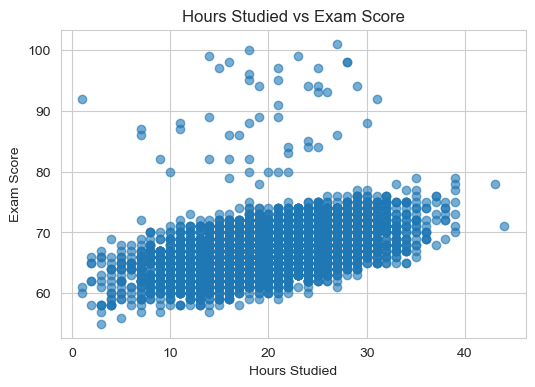

In [32]:
# Quick visualize relation between Hours_Studied and Exam_Score
plt.figure(figsize=(6,4))
plt.scatter(df['Hours_Studied'], df[target], alpha=0.6)
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Hours Studied vs Exam Score')
plt.show()

In [33]:
baseline_features = ['Hours_Studied']
extra_numeric = ['Sleep_Hours', 'Previous_Scores', 'Attendance', 'Tutoring_Sessions', 'Physical_Activity']
features = baseline_features + ['Previous_Scores']


In [34]:
df_encoded = pd.get_dummies(df, drop_first=True)

print("Some encoded columns:\n", [c for c in df_encoded.columns if 'Gender' in c or 'Parental_Involvement' in c][:10])


Some encoded columns:
 ['Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Gender_Male']


In [35]:
available = df_encoded.columns.tolist()
X_cols = []
for f in features:
    if f in available:
        X_cols.append(f)
    else:
        matches = [c for c in available if c.startswith(f + '_')]
        if matches:
            X_cols.extend(matches)

print("Using features (final):", X_cols)
X = df_encoded[X_cols].values
y = df_encoded[target].values


Using features (final): ['Hours_Studied', 'Previous_Scores']


In [36]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("train/test sizes:", X_train.shape[0], X_test.shape[0])


train/test sizes: 5285 1322


In [37]:
# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

def print_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}  MAE: {mae:.2f}  RMSE: {rmse:.2f}  R2: {r2:.3f}")

print_metrics(y_test, pred_lr, "Linear Regression")


Linear Regression  MAE: 2.41  RMSE: 3.25  R2: 0.254


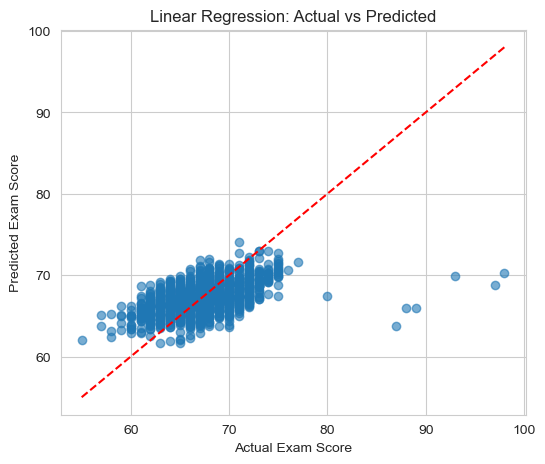

In [38]:
# Plot actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()


In [39]:
if X.shape[1] == 1:
    x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
    y_line = lr.predict(x_line)
    plt.figure(figsize=(6,5))
    plt.scatter(X, y, alpha=0.4)
    plt.plot(x_line, y_line, color='red', linewidth=2)
    plt.xlabel(X_cols[0])
    plt.ylabel('Exam Score')
    plt.title('Linear Fit')
    plt.show()


In [40]:
# --- Polynomial Regression ---
degree = 2
poly = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
poly.fit(X_train, y_train)
pred_poly = poly.predict(X_test)

print_metrics(y_test, pred_poly, f"Polynomial deg={degree}")


Polynomial deg=2  MAE: 2.41  RMSE: 3.24  R2: 0.255


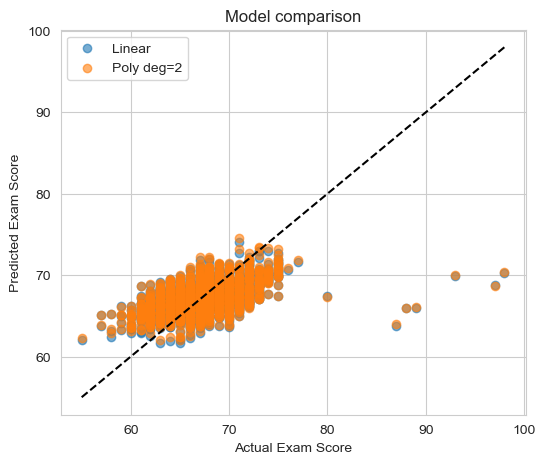

In [41]:
# Compare models visually
plt.figure(figsize=(6,5))
plt.scatter(y_test, pred_lr, label='Linear', alpha=0.6)
plt.scatter(y_test, pred_poly, label=f'Poly deg={degree}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.legend()
plt.title('Model comparison')
plt.show()


In [42]:
if 'Family_Income' in df.columns:
    print("\nAverage Exam Score by Family_Income:")
    print(df.groupby('Family_Income')[target].mean().sort_values(ascending=False).head(10))



Average Exam Score by Family_Income:
Family_Income
High      67.842396
Medium    67.334959
Low       66.848428
Name: Exam_Score, dtype: float64
